Hello,

Below you will find a tutorial on how to use AtlasOpenParser - a tool made for working with ATLAS Open Data

We will start by importing and initializing configurations


Some background first, 

ATLAS is a collaberation that utilizes data from the LHC at cern.
ATLAS Open Data provides open access to collision data and simulated events from ATLAS for educational and research purposes.

ATLAS Open Data - https://opendata.atlas.cern/ (Learn about the project)

CERN Open Data portal - https://opendata.cern.ch/ (Explore the data available)

In [ ]:
#Import the tools
from src.parse_atlas import parser
from src.calculations import physics_calcs, combinatorics
import math, awkward as ak, numpy as np
import atlasopenmagic as atom
import matplotlib.pyplot as plt
import os

: 

atlasopenmagic is a library created by ATLAS.

The library acts as an interface for metadata retrieval for ATLAS Open Data.

Below is the list of available data releases.

In [ ]:
releases = atom.available_releases()

Available releases:
2016e-8tev           2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev          2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp             2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi             2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta     2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen-13tev    2025 Open Data for research release for event generation at 13 TeV (https://opendata.cern.ch/record/160000).
2025r-evgen-13p6tev  2025 Open Data for research release for event generation at 13.6 TeV (https://opendata.cern.ch/record/160000).


In [ ]:
#Configurations
atlasparser_config = {
    # ===RELEVANT WHEN USED IN A RESTRICTED MEMORY ENV (A CLUSTER)===
    "max_environment_memory_mb": None,
    # ===RELEASE YEARS TO PARSE THE FILES FROM===  
    "release_years": ["2024r-pp"], 
    # ===AMOUNT OF THREADS TO USE MULTITHREADING WITH, 4 IS A STABLE AMOUNT===
    "max_threads": 4, 
    # ===A THRESHOLD FOR PREVENTING MEMORY OVERLOAD===
    "chunk_yield_threshold_bytes": 500_000_000, 
    # ===PATH FOR OUTPUTTING THE LOGS===
    "logging_path": "tutorial/logs/", 
    # ===SHOULD CREATE LOGGING AND DATA DIRECTORIES===
    "create_dirs": True, 
    # ===THE NAMES FOR THE DATA TREES INSIDE THE ROOT FILES, IT VARIES BY RELEASE YEAR===
    "possible_tree_names": ["CollectionTree", "mini", "analysis"], 
}

pipeline_config = {
    # ===AMOUNT OF FILES TO LIMIT EACH YEAR (MAINLY TESTING PURPOSES)===
    "limit_files_per_year": 10, 
    # ===SOMETIMES FETCHING METADATA CAN BE LONG, SO SET A TIMEOUT===
    "fetching_metadata_timeout":60,
    # ===PATH FOR OUTPUTTING THE DATA===
    "output_path": "tutorial/data/root_files/", 
}

# ===KINEMATIC CUTS===
config_kinematic_cuts = {
    "pt":{"min": 0},
    "eta":{"min": -5,"max": 5},
    "phi":{"min": -math.pi, "max": math.pi}
}

# ===FIRST FILTER FOR PARTICLE COUNTS===
config_particle_counts = {
    "Electrons" : {"min":1, "max": 6},
    "Jets" : {"min":2, "max": 8},
    "Muons" : {"min":1, "max": 6},
    "Photons" : {"min":0, "max": 5}
}

Start by initilazing the AtlasOpenParser class.

All available releases in ATLAS Open Data would also be displayed

In [ ]:
#Initializing the parser with configuration
atlasparser = parser.AtlasOpenParser(
        chunk_yield_threshold_bytes=atlasparser_config["chunk_yield_threshold_bytes"],
        max_threads=atlasparser_config["max_threads"],
        logging_path=atlasparser_config["logging_path"],
        possible_tree_names=atlasparser_config["possible_tree_names"],
        create_dirs=atlasparser_config["create_dirs"],
        release_years=atlasparser_config["release_years"],
        #TURN ON TO FETCH AND PRINT AVAILABLE RELEASES
        show_available_releases=False
        )

Fetch all release years' metadata (By configured release_years)

In [ ]:
release_years_file_ids: dict = atlasparser.fetch_record_ids(timeout=pipeline_config["fetching_metadata_timeout"])

print("====================")
print("Fetched years and their record IDs:")
for year, record_ids in release_years_file_ids.items():
    print(f"{year}: {len(record_ids)} records")

Fetching and caching all metadata for release: 2024r-pp...


Fetched 374 datasets so far...
Successfully cached 374 datasets.
Active release: 2024r-pp. (Datasets path: REMOTE)
Fetched years and their record IDs:
2024r-pp: 70201 records


Limit the files if needed (By configured limit_files_per_year)

In [ ]:
parser.AtlasOpenParser.limit_files_per_year(release_years_file_ids, pipeline_config["limit_files_per_year"])

Now using these record ids we can parse using the following pipeline ->

1. Call parse_files which yields batches according to the configured threshold

2. Apply kinematic cuts

3. Filter by particle amounts

4. And save the output

Using AtlasOpenParser class and physics_calcs module

In [ ]:
for events_chunk in atlasparser.parse_files(
    release_years_file_ids=release_years_file_ids
):
    #Show events_chunks structure for EDA
    print([(field, events_chunk[field].fields) for field in events_chunk.fields])
    
    #Cutting by kinematics
    cut_events = physics_calcs.filter_events_by_kinematics(
        events_chunk, config_kinematic_cuts
    ) 

    #Filtering events by particle amounts
    filtered_events = physics_calcs.filter_events_by_particle_counts(
        events=cut_events, 
        particle_counts=config_particle_counts, 
        is_particle_counts_range=True
    ) 

    #Prepare the events array for ROOT format
    root_ready = atlasparser.flatten_for_root(filtered_events)

    #Save the file
    atlasparser.save_events_as_root(root_ready, pipeline_config["output_path"])

Parsing files:  30%|███       | 3/10 [01:00<07:01, 60.19s/file, ✅ 0 | ❌ 4 | ✨ 0.0% | 💾 0.0 MB | 🎯 0 events]   

⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191240._000001.pool.root.1 - OSError
⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191916._000001.pool.root.1 - OSError
⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191625._000002.pool.root.1 - OSError
⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191155._000001.pool.root.1 - OSError


Parsing files:  70%|███████   | 7/10 [02:00<01:05, 21.76s/file, ✅ 0 | ❌ 8 | ✨ 0.0% | 💾 0.0 MB | 🎯 0 events]   

⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191516._000001.pool.root.1 - OSError
⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191549._000001.pool.root.1 - OSError
⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191659._000013.pool.root.1 - OSError
⚠️ Error: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191680._000001.pool.root.1 - OSError


Parsing files:  80%|████████  | 8/10 [02:24<00:36, 18.02s/file, ✅ 0 | ❌ 8 | ✨ 0.0% | 💾 0.0 MB | 🎯 0 events]


KeyboardInterrupt: 

After parsing the files

We can calculate the events' invariant masses.

Below is an example for a pipeline that calculates it.

In [ ]:
config_inv_mass_calc = {
   "input_dir": "tutorial/data/root_files",
   "output_dir": "tutorial/data/inv_masses",
   "objects_to_calculate": [
       "Electrons",
       "Muons",
       "Jets",
       "Photons"
   ],
   #===SLICE TOP X EVENTS BY COMBINATION BY THIS FIELD===
   "field_to_slice_by":"pt",
   #===MINIMUM AND MAXIMUM PARTICLES FOR IN EACH COMBINATION BY COMBINATORICS===
    "min_particles": 2,
    "max_particles": 4,
    #===MINIMUM AND MAXIMUM OF HOW MUCH OF EACH PARTICLE IN A COMBINATION===
    "min_count": 2,
    "max_count": 4
}

In [ ]:
def calculate_masses(combinations):
    for filename in os.listdir(config_inv_mass_calc["input_dir"]):
        if filename.endswith(".root"):
            print(filename)
            file_path = os.path.join(config_inv_mass_calc["input_dir"], filename)
            
            particle_arrays: ak.Array = parser.AtlasOpenParser.parse_root_file(file_path)
            print(particle_arrays)
            fs_im_mapping = {}
            for cur_fs, fs_events in physics_calcs.group_by_final_state(particle_arrays):
                if cur_fs not in fs_im_mapping:
                    fs_im_mapping[cur_fs] = {}

                for combination in combinations:
                    if not physics_calcs.is_finalstate_contain_combination(cur_fs, combination):
                        continue

                    filtered_events: ak.Array = physics_calcs.filter_events_by_particle_counts(
                        events=fs_events, 
                        particle_counts=combination
                    )    

                    sliced_events_by_pt: ak.Array = physics_calcs.slice_events_by_field(
                        events=filtered_events, 
                        particle_counts=combination,
                        field_to_slice_by=config_inv_mass_calc["field_to_slice_by"]
                    )

                    if len(sliced_events_by_pt) == 0:
                        continue
                    
                    cur_im: list = physics_calcs.calc_inv_mass(sliced_events_by_pt) 
                    
                    if not ak.any(cur_im):
                        continue
                    
                    cur_combination_name = prepare_im_combination_name(filename, cur_fs, combination)
                    
                    if cur_combination_name not in fs_im_mapping[cur_fs]:
                        fs_im_mapping[cur_fs][cur_combination_name] = cur_im
                    else:
                        combination_im = fs_im_mapping[cur_fs][cur_combination_name]
                        fs_im_mapping[cur_fs][cur_combination_name] = combination_im.extend(cur_im)
              

def save_mass_arrays(fs_im_mapping):  
    for fs, im_combinations in fs_im_mapping.items():
        for im_combination_name, im_arr in im_combinations.items():
            output_path = os.path.join(
                config_inv_mass_calc["output_dir"], 
                f"{im_combination_name}.npy" 
                )
            
            np.save(output_path, ak.to_numpy(im_arr))

def prepare_im_combination_name(filename, final_state, combination: dict) -> str:
    combination_name = ''
    combination_name += f"{filename}_FS_{final_state}_IM_"
    combination_name = get_combination_dict_repr(combination, combination_name)

    return combination_name

def get_combination_dict_repr(combination, combination_name=""):
    for object, amount in combination.items():
        combination_name += f"{amount}{object[0].lower()}_"
    
    return combination_name

os.makedirs(config_inv_mass_calc["output_dir"], exist_ok=True)
    
all_combinations = combinatorics.get_all_combinations(
    config_inv_mass_calc["objects_to_calculate"],
    min_particles=config_inv_mass_calc["min_particles"],
    max_particles=config_inv_mass_calc["max_particles"],
    min_count=config_inv_mass_calc["min_count"],
    max_count=config_inv_mass_calc["max_count"],
    limit=10)

inv_mass_arrays = calculate_masses(all_combinations)
print("===HOW THE MASSES ARE SAVED: ===")
print(inv_mass_arrays)
save_mass_arrays(inv_mass_arrays)

2024r-pp9d7c08faad247bc4.root
[{Electrons: [{pt: 8.97e+05, ...}, ...], Muons: [{...}], Jets: [...], ...}, ...]
2024r-ppf47451a3d789cf66.root
[{Electrons: [{pt: 1.1e+06, ...}, ...], Muons: [{...}], Jets: [...], ...}, ...]
2024r-pp_7c2d81e0fcbb2260.root
None


TypeError: Encountered a None value, but None conversion/promotion is disabled

Now we have invariant masses for all of the combinations calculated (here they are limited to 30 but it is configruable)

Let's create a histogram with the biggest invariant mass we have

In [ ]:
# Get all .npy files
inv_masses_raw = [f for f in os.listdir(config_inv_mass_calc["output_dir"]) if f.endswith(".npy")]
inv_masses_sizes = {f: os.path.getsize(os.path.join(config_inv_mass_calc["output_dir"], f)) for f in inv_masses_raw}
biggest_file = max(inv_masses_sizes, key=inv_masses_sizes.get)
print(f"Chosen largest file: {biggest_file} ({inv_masses_sizes[biggest_file]} bytes)")

# Sort files by size and take the 9 largest
sorted_files = sorted(inv_masses_sizes.items(), key=lambda x: x[1], reverse=True)[:9]
selected_files = [f[0] for f in sorted_files]

Chosen largest file: 2024r-pp9d7c08faad247bc4.root_1e1j_inv_mass.npy (142416 bytes)


Now let's plot the top 9 biggest invariant mass arrays side by side

In [ ]:
sorted_files

[('2024r-pp9d7c08faad247bc4.root_1e1j_inv_mass.npy', 142416),
 ('2024r-pp9d7c08faad247bc4.root_1e1m1j_inv_mass.npy', 142416),
 ('2024r-pp9d7c08faad247bc4.root_1e1m2j_inv_mass.npy', 142416),
 ('2024r-pp9d7c08faad247bc4.root_1e2j_inv_mass.npy', 142416),
 ('2024r-pp9d7c08faad247bc4.root_1j_inv_mass.npy', 142416),
 ('2024r-pp9d7c08faad247bc4.root_1m1j_inv_mass.npy', 142416),
 ('2024r-pp9d7c08faad247bc4.root_1m2j_inv_mass.npy', 142416),
 ('2024r-ppf47451a3d789cf66.root_1e1j_inv_mass.npy', 142416),
 ('2024r-ppf47451a3d789cf66.root_1e1m1j_inv_mass.npy', 142416)]

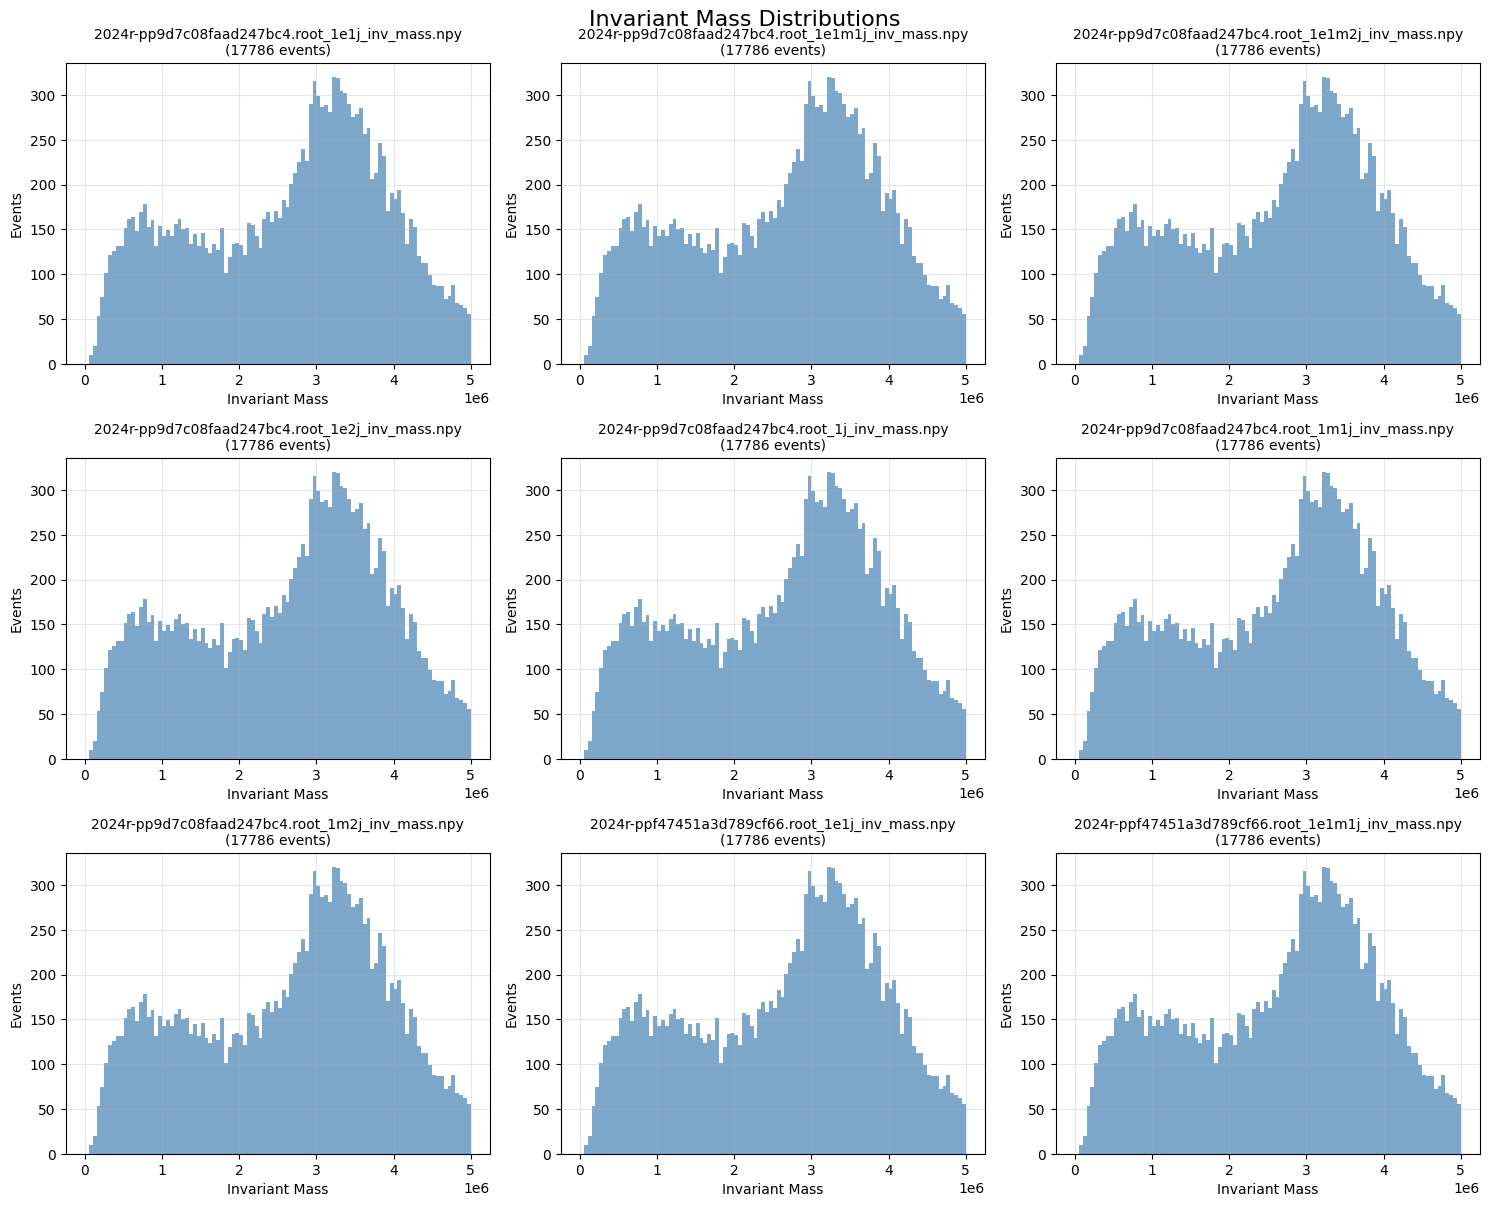

In [ ]:
# Histogram parameters
n_bins = 100
mass_min, mass_max = 0, 5000000

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Process each file
for idx, filename in enumerate(selected_files):
    file_path = os.path.join(config_inv_mass_calc["output_dir"], filename)
    inv_masses = np.load(file_path)

    # Create histogram
    bin_content, bin_edges = np.histogram(inv_masses, bins=n_bins, range=(mass_min, mass_max))
    bin_errors = np.sqrt(bin_content)

    # Plot on corresponding subplot
    ax = axes[idx]
    ax.hist(bin_edges[:-1], bins=bin_edges, weights=bin_content, alpha=0.7, color='steelblue')

    # Extract particle combination from filename
    # Format: year_<file_name>.root_FS_<final_sate>_IM_<combination>_.npy
    particle_combo = filename.split('FS')[0].split('.root_')[1]

    ax.set_xlabel('Invariant Mass')
    ax.set_ylabel('Events')
    ax.set_title(f'{filename}\n({len(inv_masses)} events)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.suptitle('Invariant Mass Distributions', fontsize=16, y=1.002)
plt.show()